In [2]:
pip install tensorflow


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached ml_dtypes-0.5.4-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using ca

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

D:\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [6]:
df_enrich = pd.read_csv('../data/enriched_nba_player_data.csv')
df_raw = pd.read_csv('../data/historic_nba_player_data.csv')
df_raw

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,Share
0,2003,Tracy McGrady,39.4,32.1,5.5,6.5,1.7,0.8,0.564,30.3,16.1,10.5,9.3,35.2,0.512,0.359
1,2003,Kobe Bryant,41.5,30.0,5.9,6.9,2.2,0.8,0.550,26.2,14.9,7.1,7.7,32.9,0.610,0.417
2,2003,Allen Iverson,42.5,27.6,5.5,4.2,2.7,0.2,0.500,21.2,9.2,3.5,4.8,32.9,0.585,0.070
3,2003,Shaquille O'Neal,37.8,27.5,3.1,11.1,0.6,2.4,0.602,29.5,13.2,6.5,5.5,30.2,0.610,0.106
4,2003,Paul Pierce,39.2,25.9,4.4,7.3,1.8,0.8,0.532,22.7,10.1,4.9,5.4,33.2,0.537,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11338,2025,Riley Minix,7.0,0.0,0.0,2.0,0.0,0.0,0.000,-1.7,0.0,-11.8,0.0,6.1,0.415,0.000
11339,2025,Jahlil Okafor,3.0,0.0,1.0,1.0,0.0,0.0,0.000,13.8,0.0,7.5,0.0,0.0,0.610,0.000
11340,2025,Zyon Pullin,1.0,0.0,0.0,0.0,0.0,0.0,0.000,-11.7,0.0,-22.7,0.0,13.4,0.585,0.000
11341,2025,Isaiah Stevens,2.0,0.0,0.0,0.7,0.3,0.0,0.000,0.1,0.0,-11.8,0.0,14.8,0.451,0.000


In [7]:
train = df_enrich[df_enrich['Season'] < 2025].copy()
test = df_enrich[df_enrich['Season'] == 2025].copy()

In [8]:
X = train[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

y = train['Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
def build_model(n_layers=2, n_units=128, dropout_rate=0.3, learning_rate=1e-3, input_dim=None):
    model = Sequential()

    # First hidden layer
    model.add(Dense(n_units, activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Additional hidden layers
    for _ in range(n_units - 1):
        model.add(Dense(n_units // 2, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output
    model.add(Dense(1, activation="relu"))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [14]:
# Test learning rates to find best performance
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3]
results = []

for lr in learning_rates:
    model = build_model(
        n_layers=2,
        n_units=128,
        dropout_rate=0.3,
        learning_rate=lr,
        input_dim=X_train.shape[1]
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        verbose=0
    )

    best_val_mae = min(history.history["val_mae"])
    results.append((lr, best_val_mae))
    print(f"LR={lr}, Best Val MAE={best_val_mae:.4f}")

LR=0.0001, Best Val MAE=0.0063
LR=0.0003, Best Val MAE=0.0063
LR=0.001, Best Val MAE=0.0063
LR=0.003, Best Val MAE=0.0063


All tested learning rates perform the same, we will select a rate of 0.001 to train models faster

In [20]:
# Test different layer architectures
layers = [
    (1, 2),
    (1, 3),
    (2, 2),
    (2, 4),
    (3, 4)
]

results = []

for n_layers, n_units in layers:
    model = build_model(
        n_layers=n_layers,
        n_units=n_units,
        dropout_rate=0.3,
        learning_rate=1e-3,
        input_dim=X.shape[1]
    )

    history = model.fit(
        X, y,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        verbose=0
    )

    best_val_mae = min(history.history["val_mae"])
    results.append((n_layers, n_units, best_val_mae))

    print(f"Layers={n_layers}, Units={n_units}, Val MAE={best_val_mae:.4f}")

Layers=1, Units=2, Val MAE=0.0045
Layers=1, Units=3, Val MAE=0.0045
Layers=2, Units=2, Val MAE=0.0045
Layers=2, Units=4, Val MAE=0.0045
Layers=3, Units=4, Val MAE=0.0045


Even very small networks produce similar errors to large ones suggesting architectural changes do not improve performance

In [33]:
nn = Sequential([
    Dense(2, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation="relu")
])

nn.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )

nn.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0809 - mae: 0.1775 
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0190 - mae: 0.0599 
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 - mae: 0.0302 
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 - mae: 0.0195 
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - mae: 0.0141 
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - mae: 0.0115 
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - mae: 0.0103     
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0087 
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0082 
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0075     
Epoch 11/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0072 
Epoch 12/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0066 
Epoch

In [37]:
yhat = np.clip(nn.predict(X_test), a_min=0, a_max=None)
base = np.zeros(len(yhat))

mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
baseline = mean_absolute_error(y_test, base)

print('Mean Absolute Error:', mae)
print('Baseline', baseline)
print('r2 score:', r2)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Error: 0.0037227445020848854
Baseline 0.0051538024971623155
r2 score: 0.722239556502482


In [38]:
df_val = train.copy()
df_val.loc[X_test.index, 'yhat'] = yhat

In [39]:
df_val = df_val.dropna().sort_values(by=['yhat', 'Share'], ascending=False)
df_val[['Season', 'Player', 'Share', 'yhat']].head(15)

,Season,Player,Share,yhat
2191,2009,LeBron James,0.969,1.244427
3710,2013,LeBron James,0.998,1.039181
7442,2022,Giannis Antetokounmpo,0.595,0.681899
5294,2017,Russell Westbrook,0.879,0.628714
6568,2020,James Harden,0.363,0.616690
3301,2012,Kevin Durant,0.735,0.557669
8367,2024,Shai Gilgeous-Alexander,0.646,0.456768
718,2005,Dirk Nowitzki,0.275,0.445879
6579,2020,Anthony Davis,0.081,0.427341
1467,2007,LeBron James,0.142,0.420620


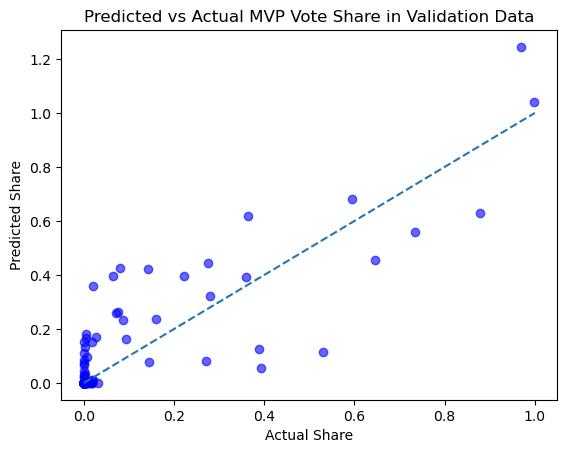

In [40]:
plt.scatter(y_test, yhat, alpha=0.6, color='b')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Validation Data")
plt.show()

In [42]:
X_2025 = test[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

pred_2025 = test.copy()
pred_2025['yhat'] = np.clip(nn.predict(X_2025), a_min=0, a_max=None)
pred_2025[['Player', 'Share', 'yhat']].sort_values(by=['yhat'], ascending=False).head(25)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Player,Share,yhat
8809,Shai Gilgeous-Alexander,0.913,1.138279
8811,Nikola Jokić,0.787,0.736230
8810,Giannis Antetokounmpo,0.470,0.415436
8814,Jayson Tatum,0.311,0.264980
8921,Tolu Smith,0.000,0.176872
8827,LeBron James,0.016,0.151861
8826,Stephen Curry,0.002,0.128939
9081,Oscar Tshiebwe,0.000,0.108403
8871,Evan Mobley,0.001,0.089352
8813,Anthony Edwards,0.012,0.085907


In [44]:
base = np.zeros(len(pred_2025))

mae_test = mean_absolute_error(pred_2025['yhat'], pred_2025['Share'])
baseline = mean_absolute_error(base, pred_2025['Share'])

print("Test MAE:", mae_test)
print("Baseline MAE:", baseline)
print("R2 score:", r2_score(pred_2025['Share'], pred_2025['yhat']))

Test MAE: 0.0029130278540694192
Baseline MAE: 0.005652173913043478
R2 score: 0.908732311436472


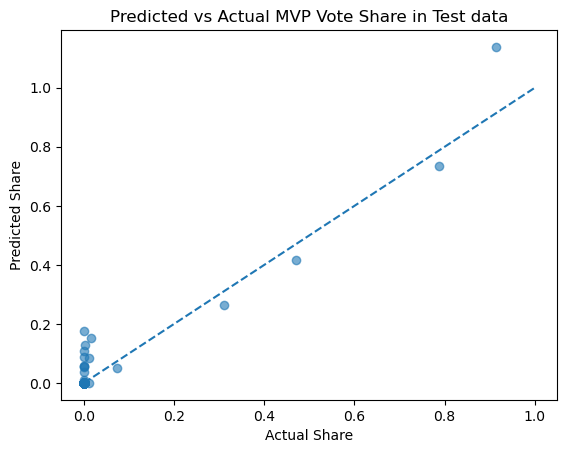

In [43]:
plt.scatter(pred_2025['Share'], pred_2025['yhat'], alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Test data")
plt.show()

Notes:
- Neural Network is outperformed by forest based models on this dataset
- Suffers from the same problem of overpredicting players with low vote share